In [ ]:
# Project 7 – Sheikh Islam, Wilson Jimenez, Talha Akhlaq
# PyMC implementation of Bayesian Change-Point Model (based on Yıldırım 2012)

import numpy as np
import matplotlib.pyplot as plt
import pymc as pm

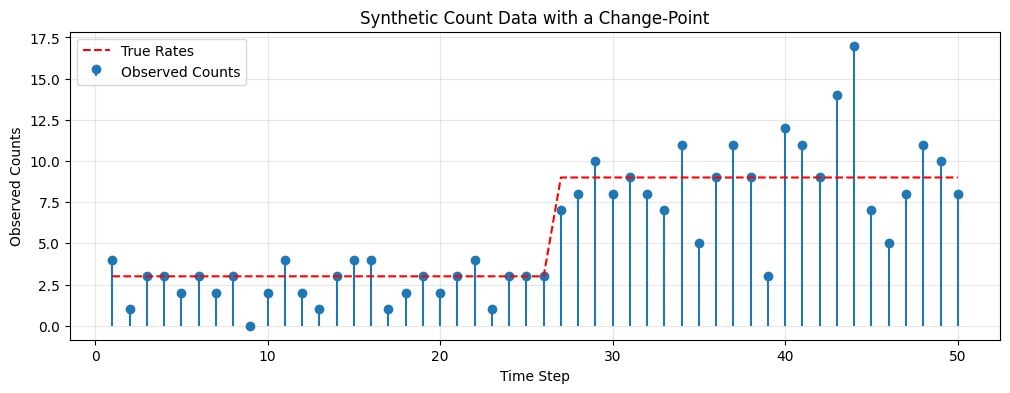

Output()

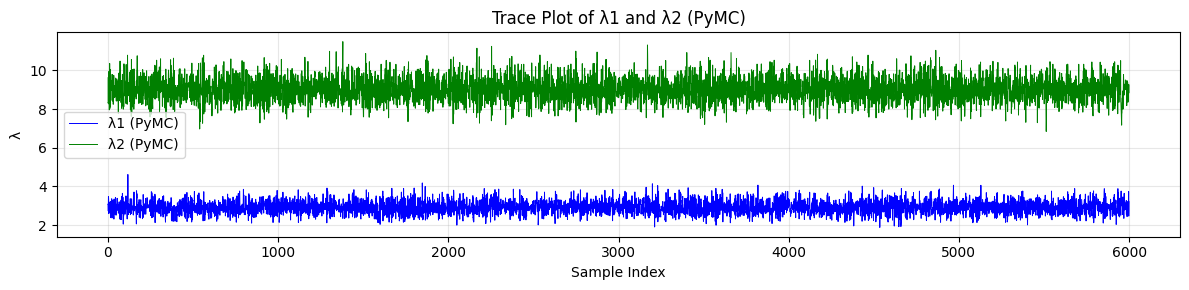

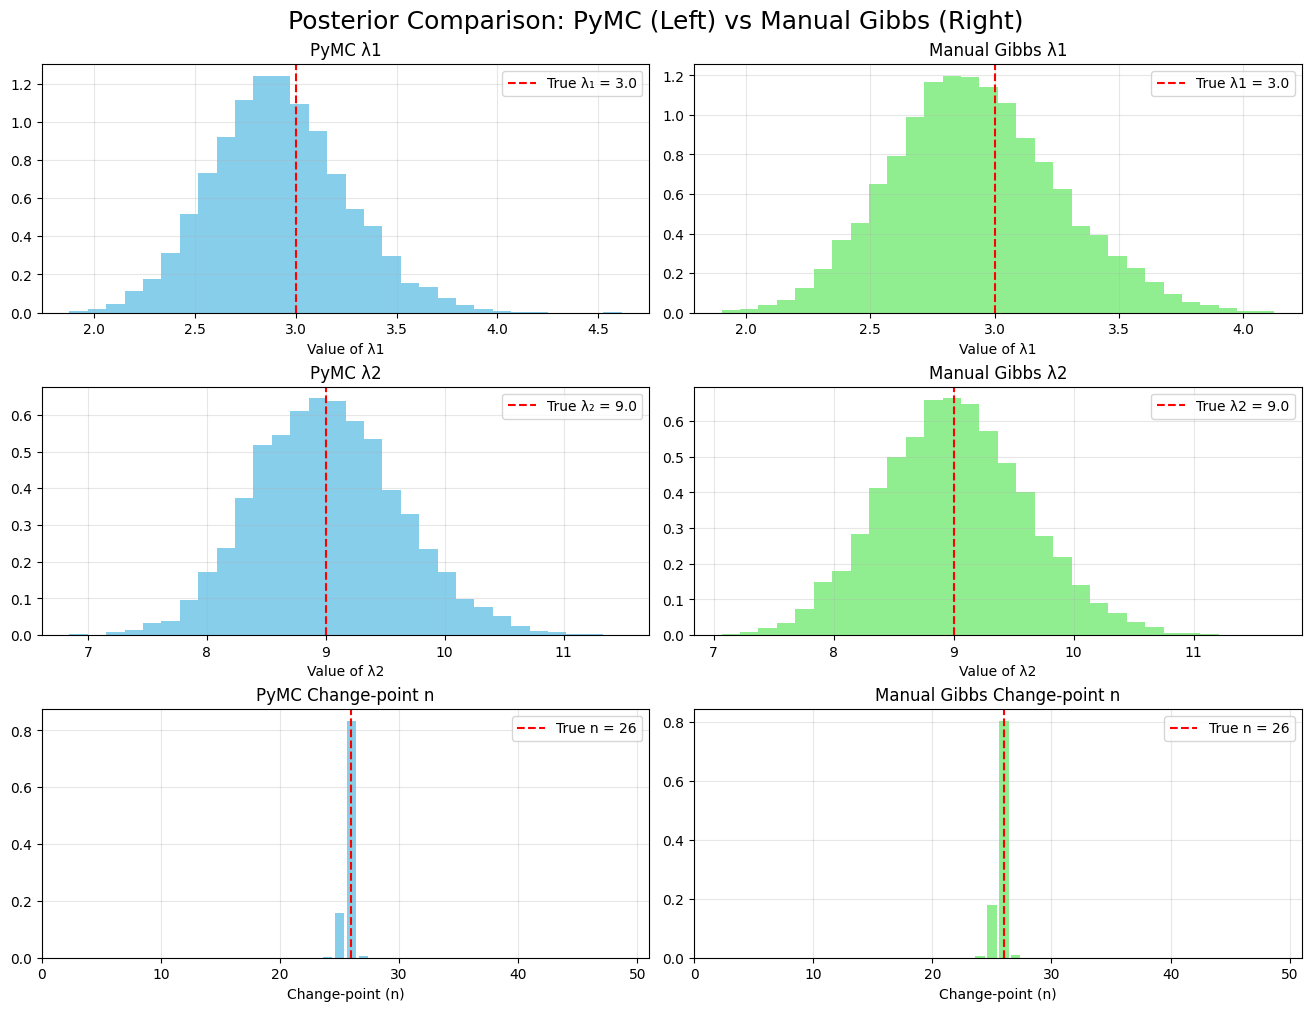

In [ ]:
#Pre-defined values from the paper
N = 50
n_true = 26
lambda1_true = 3.0
lambda2_true = 9.0
rng = np.random.default_rng(42)

x = np.where(np.arange(N) < n_true, rng.poisson(lambda1_true, N), rng.poisson(lambda2_true, N))

# Generating poisson distributed counts
# At the n change point we switched the rate from lambda1 to lambda2
np.random.seed(42)
counts = np.zeros(N, dtype=np.int32)
counts[:n_true] = np.random.poisson(lambda1_true, size=n_true)
counts[n_true:] = np.random.poisson(lambda2_true, size=N - n_true)
lambdas_true = np.where(np.arange(N) < n_true, lambda1_true, lambda2_true)

fig, ax = plt.subplots(figsize=(12, 4))
ax.stem(np.arange(1, N + 1), counts, linefmt='C0-', markerfmt='C0o', basefmt=" ", label="Observed Counts")
ax.plot(np.arange(1, N + 1), lambdas_true, 'r--', label='True Rates')
ax.set_title('Synthetic Count Data with a Change-Point')
ax.set_xlabel('Time Step')
ax.set_ylabel('Observed Counts')
ax.legend()
ax.grid(alpha=0.3)
plt.show()

#Creating a model through pymc to create our lambda predicitions and change point
with pm.Model() as model:
    n = pm.DiscreteUniform('n', lower=1, upper=N)
    λ1 = pm.Gamma('λ1', alpha=2, beta=1)
    λ2 = pm.Gamma('λ2', alpha=2, beta=1)
    μ = pm.math.switch(np.arange(N) < n, λ1, λ2)
    y_obs = pm.Poisson('y', mu=μ, observed=x)
    trace = pm.sample(3000, tune=1000, cores=1, progressbar=True)

#Posterior Plot
lambda1_samples = trace.posterior['λ1'].values.ravel()
lambda2_samples = trace.posterior['λ2'].values.ravel()
n_samples  = trace.posterior['n'].values.ravel()

#Taking our lambda1
fig, ax = plt.subplots(figsize=(12, 3))
ax.plot(lambda1_samples, color='blue', label='λ1 (PyMC)', linewidth=0.7)
ax.plot(lambda2_samples, color='green', label='λ2 (PyMC)', linewidth=0.7)
ax.set_xlabel('Sample Index')
ax.set_ylabel('λ')
ax.set_title('Trace Plot of λ1 and λ2 (PyMC)')
ax.legend()
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

fig, axs = plt.subplots(3, 2, figsize=(13, 10), constrained_layout=True)
fig.suptitle("Posterior Comparison: PyMC (Left) vs Manual Gibbs (Right)", fontsize=18)

# PyMc lambda 1
axs[0, 0].hist(lambda1_samples, bins=30, density=True, color='skyblue')
axs[0, 0].axvline(lambda1_true, color='red', linestyle='--', label=f'True λ₁ = {lambda1_true}')
axs[0, 0].set_title("PyMC λ1")
axs[0, 0].set_xlabel("Value of λ1")
axs[0, 0].grid(alpha=0.3)
axs[0, 0].legend()

# PyMc lambda 2
axs[1, 0].hist(lambda2_samples, bins=30, density=True, color='skyblue')
axs[1, 0].axvline(lambda2_true, color='red', linestyle='--', label=f'True λ₂ = {lambda2_true}')
axs[1, 0].set_title("PyMC λ2")
axs[1, 0].set_xlabel("Value of λ2")
axs[1, 0].grid(alpha=0.3)
axs[1, 0].legend()

# PyMc change point
axs[2, 0].hist(n_samples, bins=np.arange(0.5, N+1.5), rwidth=0.8, density=True, color='skyblue')
axs[2, 0].axvline(n_true, color='red', linestyle='--', label=f'True n = {n_true}')
axs[2, 0].set_title("PyMC Change-point n")
axs[2, 0].set_xlabel("Change-point (n)")
axs[2, 0].set_xlim(0, N+1)
axs[2, 0].grid(alpha=0.3)
axs[2, 0].legend()

#STRETCH GOAL
a, b = 2., 1.
burn, draws = 200, 5_000
lambda1, lambda2, n = np.empty(draws+burn), np.empty(draws+burn), np.empty(draws+burn, dtype=int)
lambda1[0] = rng.gamma(a, 1/b)
lambda2[0] = rng.gamma(a, 1/b)
n[0] = rng.integers(1, N+1)
cumsum = np.cumsum(x)
total = cumsum[-1]

for t in range(1, draws+burn):
    #equation 8 from paper
    s1 = cumsum[n[t-1]-1]
    lambda1[t] = rng.gamma(a + s1, 1/(n[t-1] + b))
    # equation 9 from paper
    s2 = total - s1
    lambda2[t] = rng.gamma(a + s2, 1/(N - n[t-1] + b))
    # equation 10 from paper
    j   = np.arange(1, N+1)
    logp=  cumsum*np.log(lambda1[t]) - j*lambda1[t] + (total-cumsum)*np.log(lambda2[t]) - (N-j)*lambda2[t]
    p   = np.exp(logp - logp.max());  p /= p.sum()
    n[t]= rng.choice(j, p=p)

lambda1_gibbs, lambda2_gibbs, n_gibbs = lambda1[burn:], lambda2[burn:], n[burn:]

# Manual gibbs sample for lambda 1
axs[0, 1].hist(lambda1_gibbs, bins=30, density=True, color='lightgreen')
axs[0, 1].axvline(lambda1_true, color='red', linestyle='--', label=f'True λ1 = {lambda1_true}')
axs[0, 1].set_title("Manual Gibbs λ1")
axs[0, 1].set_xlabel("Value of λ1")
axs[0, 1].legend()
axs[0, 1].grid(alpha=0.3)

# Manual gibbs sample for lambda lambda 2
axs[1, 1].hist(lambda2_gibbs, bins=30, density=True, color='lightgreen')
axs[1, 1].axvline(lambda2_true, color='red', linestyle='--', label=f'True λ2 = {lambda2_true}')
axs[1, 1].set_title("Manual Gibbs λ2")
axs[1, 1].set_xlabel("Value of λ2")
axs[1, 1].legend()
axs[1, 1].grid(alpha=0.3)

# Manual gibbs sample for lambda change point
axs[2, 1].hist(n_gibbs, bins=np.arange(0.5, N+1.5), rwidth=0.8, density=True, color='lightgreen')
axs[2, 1].axvline(n_true, color='red', linestyle='--', label=f'True n = {n_true}')
axs[2, 1].set_title("Manual Gibbs Change-point n")
axs[2, 1].set_xlabel("Change-point (n)")
axs[2, 1].set_xlim(0, N+1)
axs[2, 1].legend()
axs[2, 1].grid(alpha=0.3)

plt.show()